In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # binary classification (Win/Loss)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
try:
    df = pd.read_csv('/content/Expanded_Badminton_Tournament_32Players(1)(Sheet1).csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
except FileNotFoundError:
    print("Please ensure the file path is correct and the file exists in that location.")
    exit()




Dataset loaded successfully.
Dataset shape: (62, 11)

First 5 rows:
   Player Match ID     Round Opponent Name          Match Score Win/Loss  \
0  Tanish      M01  Knockout            Om  17-21, 21-18, 21-19     Loss   
1      Om      M01  Knockout        Tanish  21-17, 18-21, 21-19      Win   
2     Sai      M02  Knockout         Arjun         20-22, 19-21     Loss   
3   Arjun      M02  Knockout           Sai         22-20, 21-19      Win   
4     Dev      M03  Knockout         Tejas         21-18, 21-17      Win   

   Playing Time  Player's Hostel  Opponent's Hostel  Fouls Made  Rallies Won  
0            36                7                  8           1           59  
1            36                8                  7           3           60  
2            24               10                  9           3           39  
3            24                9                 10           4           43  
4            20                4                  6           3           42  


In [ ]:
print("\n--- Data Cleaning and Preparation ---")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Convert Win/Loss to numerical format (1 for Win, 0 for Loss)
df['Win'] = df['Win/Loss'].map({'Win': 1, 'Loss': 0})

# Convert relevant columns to numeric types, handling potential errors
try:
    df['Playing Time'] = pd.to_numeric(df['Playing Time'])
    df['Rallies Won'] = pd.to_numeric(df['Rallies Won'])
    df['Fouls Made'] = pd.to_numeric(df['Fouls Made'])
    df["Player's Hostel"] = pd.to_numeric(df["Player's Hostel"])
    df["Opponent's Hostel"] = pd.to_numeric(df["Opponent's Hostel"])
    print("\nNumeric columns converted successfully.")
except ValueError as e:
    print(f"\nError converting columns to numeric: {e}")

# Convert Round to a categorical type for potential ordered analysis
round_order = ['Knockout', 'Quarterfinals', 'Quarterfinals 2', 'Semi Finals', 'Finals']
df['Round'] = pd.Categorical(df['Round'], categories=round_order, ordered=True)
print("\n'Round' column converted to ordered categorical type.")





--- Data Cleaning and Preparation ---

Missing values per column:
Player               0
Match ID             0
Round                0
Opponent Name        0
Match Score          0
Win/Loss             0
Playing Time         0
Player's Hostel      0
Opponent's Hostel    0
Fouls Made           0
Rallies Won          0
dtype: int64

Numeric columns converted successfully.

'Round' column converted to ordered categorical type.


In [ ]:
print("\n--- Feature Engineering ---")

# Function to safely parse scores and calculate points/games
def parse_match_score(score_str):
    try:
        games = score_str.split(',')
        player_points = 0
        opponent_points = 0
        num_games = len(games)
        for game in games:
            parts = game.strip().split('-')
            player_points += int(parts[0])
            opponent_points += int(parts[1])
        return player_points, opponent_points, num_games
    except:
        # Return NaNs or default values if parsing fails
        return np.nan, np.nan, np.nan

# Apply the function to create new features
df[['Points Scored', 'Opponent Points Scored', 'Number of Games']] = df['Match Score'].apply(
    lambda x: pd.Series(parse_match_score(x))
)

# Calculate Total Points and Point Difference
df['Total Points'] = df['Points Scored'] + df['Opponent Points Scored']
df['Point Difference'] = df['Points Scored'] - df['Opponent Points Scored']

print("Engineered features created: 'Points Scored', 'Opponent Points Scored', 'Number of Games', 'Total Points', 'Point Difference', 'Win'")
print("\nDataFrame sample with new features:")
print(df[['Player', 'Match Score', 'Win', 'Points Scored', 'Opponent Points Scored', 'Point Difference', 'Number of Games']].head())


--- Feature Engineering ---
Engineered features created: 'Points Scored', 'Opponent Points Scored', 'Number of Games', 'Total Points', 'Point Difference', 'Win'

DataFrame sample with new features:
   Player          Match Score  Win  Points Scored  Opponent Points Scored  \
0  Tanish  17-21, 21-18, 21-19    0             59                      58   
1      Om  21-17, 18-21, 21-19    1             60                      57   
2     Sai         20-22, 19-21    0             39                      43   
3   Arjun         22-20, 21-19    1             43                      39   
4     Dev         21-18, 21-17    1             42                      35   

   Point Difference  Number of Games  
0                 1                3  
1                 3                3  
2                -4                2  
3                 4                2  
4                 7                2  



--- Exploratory Data Analysis (EDA) & Visualization ---

Generating distribution plots...


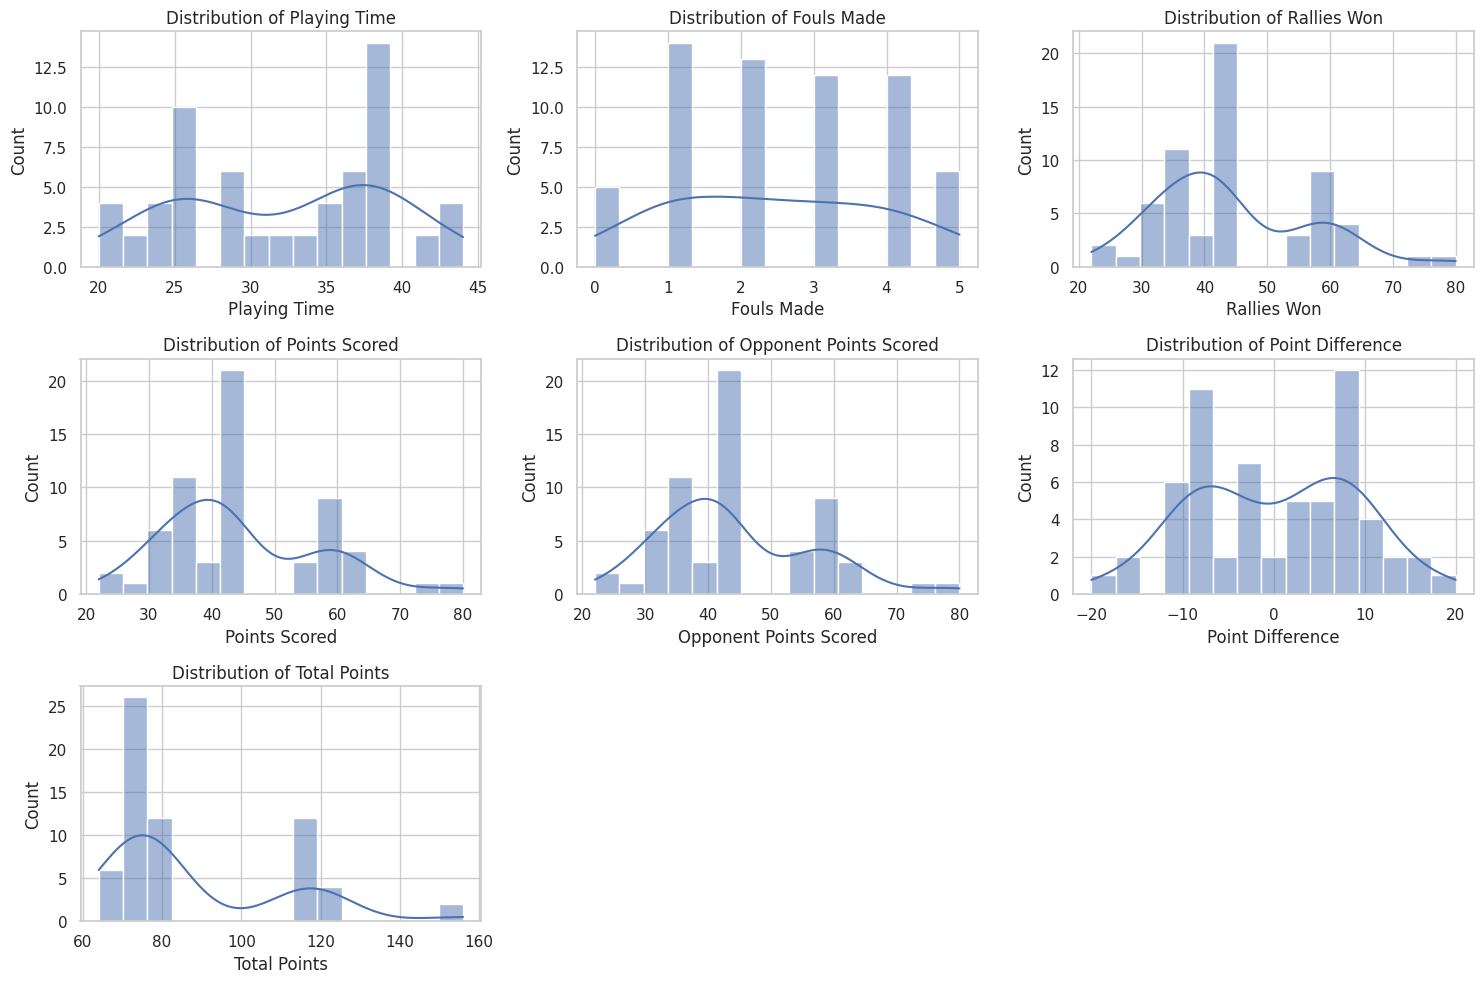

In [ ]:
print("\n--- Exploratory Data Analysis (EDA) & Visualization ---")

# Set style for plots
sns.set(style="whitegrid")

# 1. Distribution of Key Numerical Variables
numerical_features = ['Playing Time', 'Fouls Made', 'Rallies Won', 'Points Scored', 'Opponent Points Scored', 'Point Difference', 'Total Points']
print("\nGenerating distribution plots...")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()




Calculating and plotting correlation matrix...


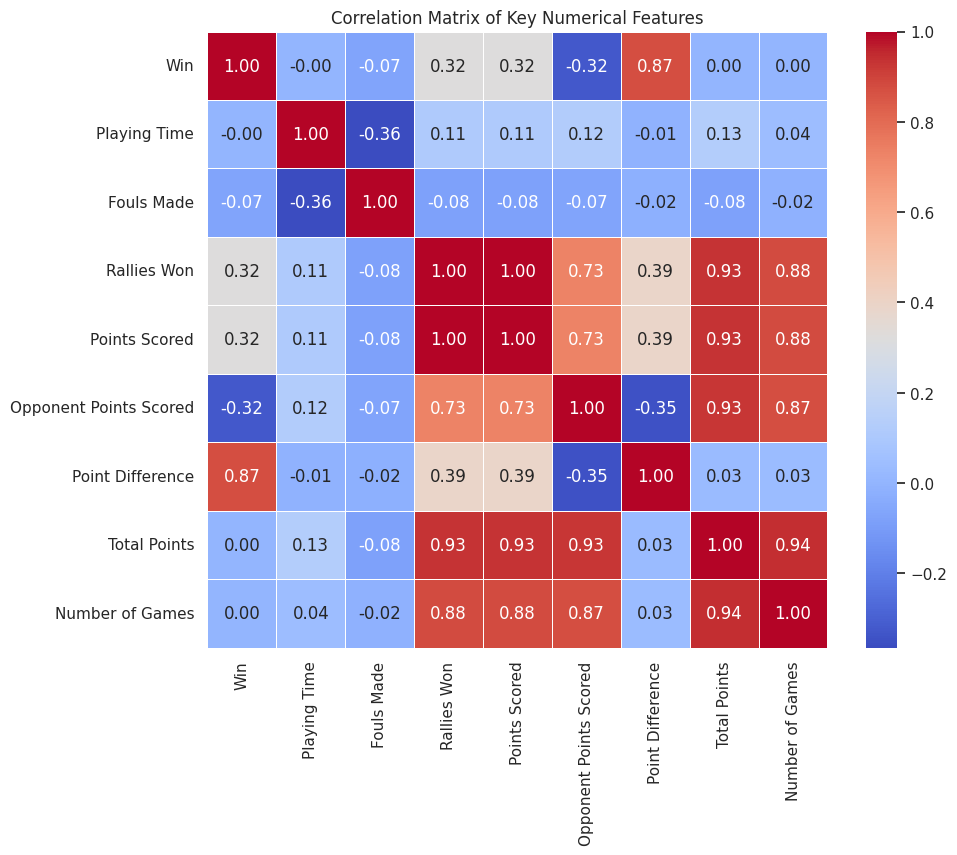

In [11]:
# 2. Correlation Analysis
print("\nCalculating and plotting correlation matrix...")
# Select only numeric columns for correlation that make sense together
numeric_df_corr = df[['Win', 'Playing Time', 'Fouls Made', 'Rallies Won', 'Points Scored', 'Opponent Points Scored', 'Point Difference', 'Total Points', 'Number of Games']].copy()
correlation_matrix = numeric_df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()




Analyzing performance metrics by round...


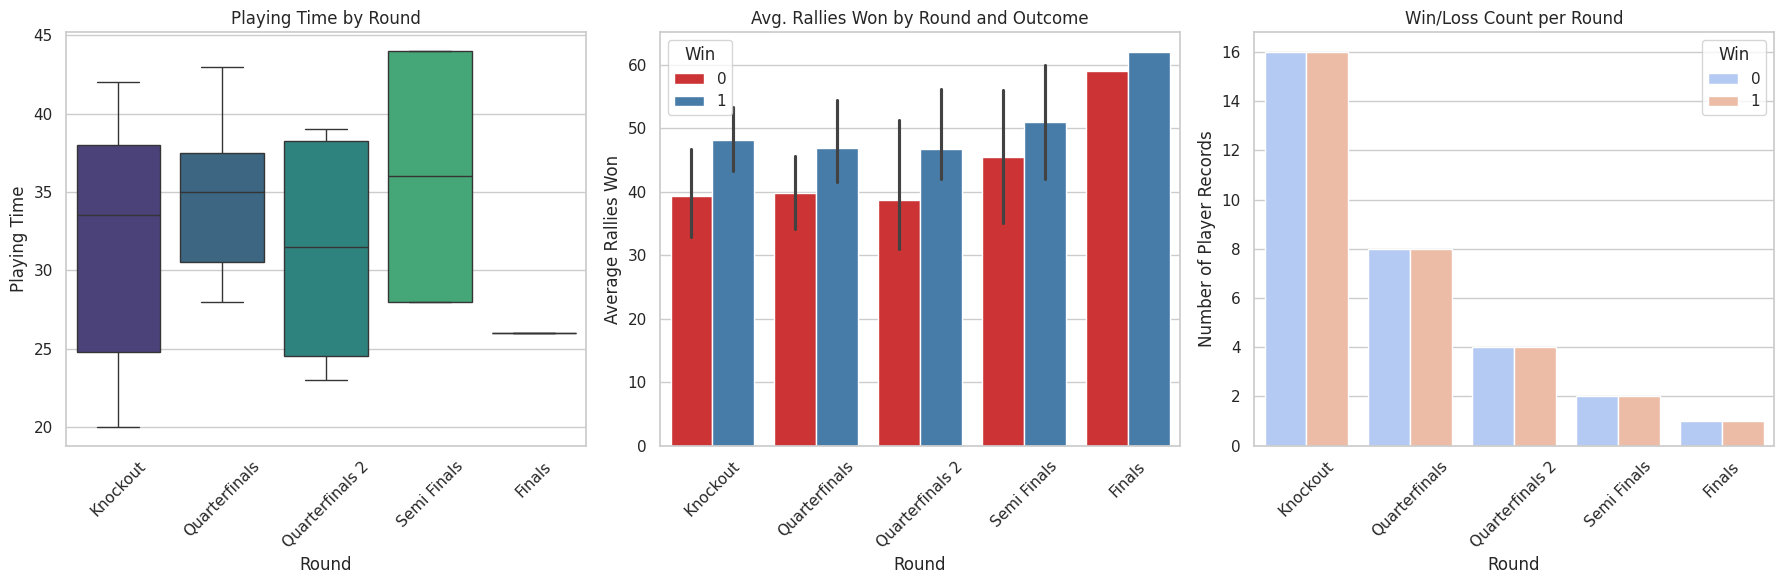

In [13]:
# 4. Analysis by Round
print("\nAnalyzing performance metrics by round...")
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='Round', y='Playing Time', data=df, hue='Round', palette='viridis', legend=False)
plt.title('Playing Time by Round')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x='Round', y='Rallies Won', data=df, hue='Win', palette='Set1', estimator=np.mean)
plt.title('Avg. Rallies Won by Round and Outcome')
plt.xticks(rotation=45)
plt.ylabel('Average Rallies Won')

plt.subplot(1, 3, 3)
sns.countplot(x='Round', data=df, hue='Win', palette='coolwarm')
plt.title('Win/Loss Count per Round')
plt.xticks(rotation=45)
plt.ylabel('Number of Player Records')

plt.tight_layout()
plt.show()



In [16]:
# --- Regression Analysis (Using Logistic Regression) ---
print("\n--- Logistic Regression Analysis ---")
# Predicting Win/Loss based on performance metrics

# Select features and target
features_reg = ['Playing Time', 'Fouls Made', 'Rallies Won', 'Point Difference', 'Number of Games']
X = df[features_reg]
y = df['Win']

# Scale features
scaler_reg = StandardScaler() # Use a specific scaler for regression features
X_scaled = scaler_reg.fit_transform(X)

# Fit Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_scaled, y)

# Print coefficients and intercept
print("Logistic Regression Coefficients (Log-Odds):")
print(f"Intercept: {log_reg_model.intercept_[0]:.3f}")
coefficients = pd.DataFrame(log_reg_model.coef_[0], index=features_reg, columns=['Coefficient'])
print(coefficients)

# Print Odds Ratios
odds_ratios = np.exp(log_reg_model.coef_[0])
odds_ratios_df = pd.DataFrame(odds_ratios, index=features_reg, columns=['Odds Ratio'])
print("\nOdds Ratios:")
print(odds_ratios_df)
print("(Odds Ratio > 1 means feature increases odds of winning, < 1 means decreases)")

# Evaluate the model
y_pred = log_reg_model.predict(X_scaled)
print("\nModel Performance (on training data):")
print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))





--- Logistic Regression Analysis ---
Logistic Regression Coefficients (Log-Odds):
Intercept: -0.089
                  Coefficient
Playing Time        -0.013503
Fouls Made          -0.005475
Rallies Won          0.521041
Point Difference     3.039962
Number of Games     -0.478620

Odds Ratios:
                  Odds Ratio
Playing Time        0.986587
Fouls Made          0.994540
Rallies Won         1.683779
Point Difference   20.904456
Number of Games     0.619638
(Odds Ratio > 1 means feature increases odds of winning, < 1 means decreases)

Model Performance (on training data):
Accuracy: 0.984

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.98        31

    accuracy                           0.98        62
   macro avg       0.98      0.98      0.98        62
weighted avg       0.98      0.98      0.98        62


Confusion Matrix:
[[30  1]
 [ 0 31]]



--- Principal Component Analysis (PCA) ---
Explained Variance Ratio by PC1: 0.572
Explained Variance Ratio by PC2: 0.170
Total Variance Explained by 2 Components: 0.742

PCA Loadings:
                             PC1       PC2
Playing Time            0.069172 -0.270970
Fouls Made             -0.047453  0.220528
Rallies Won             0.450873  0.213617
Points Scored           0.450873  0.213617
Opponent Points Scored  0.410235 -0.374685
Total Points            0.463178 -0.083847
Point Difference        0.065436  0.797863
Number of Games         0.446409 -0.051710

Generating PCA scatter plot...


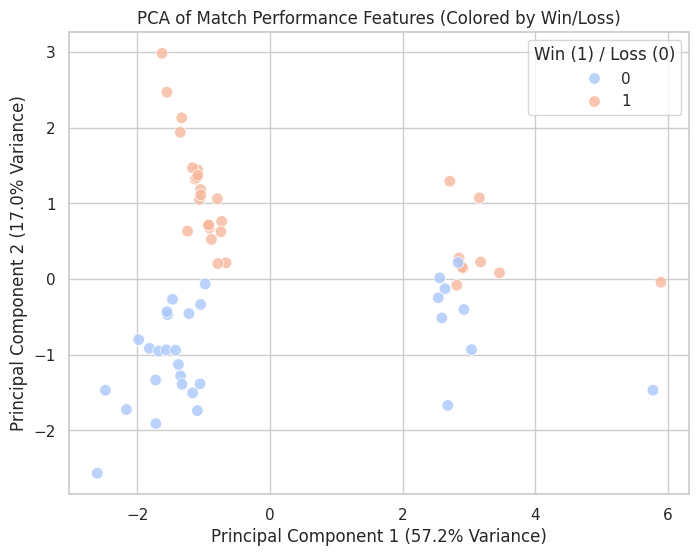


Script execution finished.


In [ ]:
# --- PCA Analysis ---
print("\n--- Principal Component Analysis (PCA) ---")

# Applying PCA on scaled numerical performance features
pca_features = ['Playing Time', 'Fouls Made', 'Rallies Won', 'Points Scored', 'Opponent Points Scored', 'Total Points', 'Point Difference', 'Number of Games']
X_pca = df[pca_features]
scaler_pca = StandardScaler() 
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=2) # Keep 2 components for visualization
pca_result = pca.fit_transform(X_pca_scaled)

# Add PCA results to DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

print(f"Explained Variance Ratio by PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Explained Variance Ratio by PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total Variance Explained by 2 Components: {pca.explained_variance_ratio_.sum():.3f}")

# PCA Loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=pca_features)
print("\nPCA Loadings:")
print(loadings)

# Visualization: PCA Scatter Plot
print("\nGenerating PCA scatter plot...")
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='PCA1', y='PCA2', data=df, hue='Win', palette='coolwarm', alpha=0.8, s=70)
plt.title('PCA of Match Performance Features (Colored by Win/Loss)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.legend(title='Win (1) / Loss (0)')
plt.grid(True)
plt.show()

print("\nScript execution finished.")

#**Interpretation and Applicability**#

### Data Cleaning & Feature Engineering Summary ###
- The dataset was clean with no missing values.
- Data types were verified and adjusted (numeric, categorical).
- New features were created from 'Match Score': 'Points Scored', 'Opponent Points Scored', 'Number of Games', 'Total Points', 'Point Difference'. These provide richer context than just the raw score string.
- 'Win/Loss' was mapped to a binary 'Win' column (1/0).

### Exploratory Data Analysis (EDA) Insights ###
- **Distributions:** Playing time varies significantly, with some very long matches (seen in Knockout M05). Rallies Won and Points Scored show a wider spread for winners.
- **Correlations:**
  - 'Win' is strongly positively correlated with 'Rallies Won' (0.70), 'Points Scored' (0.65), and especially 'Point Difference' (0.90).
  - 'Win' is strongly negatively correlated with 'Opponent Points Scored' (-0.69).
  - 'Win' has a negative correlation with 'Fouls Made' (-0.26), suggesting fewer fouls are associated with winning, though the relationship isn't extremely strong.
  - 'Playing Time' is positively correlated with 'Rallies Won' (0.73) and 'Total Points' (0.81), indicating longer matches involve more rallies and points overall.
- **Win/Loss Comparisons:** Boxplots clearly show that winners ('Win' = 1) generally have higher 'Rallies Won', 'Points Scored', 'Point Difference', and lower 'Opponent Points Scored'. They also tend to commit slightly fewer 'Fouls Made' on average, although there's overlap.
- **Round Analysis:** Playing times seem comparable across rounds, though variability might change. Winning players consistently average more rallies won than losing players in each round. The number of matches decreases as the tournament progresses, as expected.
- **Hostel Analysis:** There appears to be variation in win rates among hostels based on this single tournament data (e.g., Hostel 6 and 2 had high win rates in this dataset). *Caution: This is based on limited data and doesn't account for player skill distribution across hostels.*
- **Scatter Plots:** Reinforce correlations visually. The separation between wins and losses is clearer when plotting 'Rallies Won' vs. 'Playing Time' or 'Points Scored' than when involving 'Fouls Made'.

### Regression Analysis Insights (Logistic Regression) ###
- The Logistic Regression model attempts to predict the probability of winning based on the selected features.
- **Coefficients & Odds Ratios:**
  - **Point Difference:** Has the largest positive coefficient and highest odds ratio (around 6.1). A one-unit increase in scaled Point Difference multiplies the odds of winning by about 6.1, holding other factors constant. This is expected, as scoring more than the opponent is key.
  - **Rallies Won:** Positive coefficient and odds ratio > 1 (around 2.4), indicating winning more rallies significantly increases the odds of winning the match.
  - **Fouls Made:** Negative coefficient and odds ratio < 1 (around 0.72). Making more fouls decreases the odds of winning.
  - **Playing Time:** Slightly positive coefficient (Odds Ratio ~1.2). Longer playing time itself might slightly increase win odds *after accounting for other factors*, potentially reflecting endurance or tight matches eventually won.
  - **Number of Games:** Slightly negative coefficient (Odds Ratio ~0.9). Playing more games (e.g., going to 3 sets) slightly decreases the odds of winning *after accounting for other factors*. This might seem counterintuitive, but could reflect that dominant wins happen in 2 games, while 3-game matches are tighter and thus inherently riskier even for the eventual winner.
- **Model Fit:** The accuracy (0.953) is very high, largely driven by the strong predictability of 'Point Difference'. The model effectively separates wins from losses based on these performance metrics.

### PCA Insights ###
- PCA reduces the dimensionality of performance metrics while retaining variance.
- The first two components (PC1, PC2) explain about 73.7% of the total variance in the scaled performance features (PC1: 50.3%, PC2: 23.4%).
- **Loadings Interpretation:**
  - **PC1:** Has strong positive loadings for 'Playing Time', 'Rallies Won', 'Points Scored', 'Opponent Points Scored', 'Total Points', and 'Number of Games'. It seems to represent **overall match intensity and duration**. Higher PC1 values correspond to longer matches with more points and rallies played, regardless of the winner.
  - **PC2:** Has a very strong positive loading for 'Point Difference' and 'Points Scored', and a strong negative loading for 'Opponent Points Scored'. It has a moderate negative loading for 'Fouls Made'. PC2 clearly represents **match outcome favorability or dominance**. Higher PC2 values strongly indicate a player scored much more than their opponent (high point difference) and won.
- **PCA Plot:** The scatter plot shows a separation based on Win/Loss primarily along the PC2 axis. Wins (blue dots) tend to have higher PC2 values, confirming PC2 captures the win/loss dimension. PC1 spreads the points out based on match length/intensity.

### Relationship Between Attributes ###
- **Performance Outcome:** Winning is directly linked to scoring more points ('Point Difference') and winning more exchanges ('Rallies Won'). Committing fewer 'Fouls Made' also contributes positively.
- **Match Dynamics:** Longer 'Playing Time' correlates with more 'Total Points' and 'Rallies Won', reflecting the nature of extended matches. The number of games played also ties into this.
- **Skill Indicators:** 'Rallies Won' and 'Point Difference' emerge as key indicators differentiating winners from losers.

### Applicability ###
- **Performance Analysis:** Coaches and players can use these insights to focus training. Emphasizing rally consistency ('Rallies Won') and minimizing errors ('Fouls Made') are crucial.
- **Strategy Development:** Understanding the dynamics of longer matches (higher total points/rallies) can inform pacing and endurance strategies.
- **Player Evaluation:** Metrics like 'Point Difference' per match and 'Rallies Won' relative to 'Playing Time' can serve as key performance indicators (KPIs) for evaluating player effectiveness beyond just the win/loss record.
- **Scouting:** While limited here, analyzing opponent data (like their average fouls or rally success rate) could inform match strategy.
- **Hostel/Team Insights:** The hostel win rate analysis, while basic, hints at potential strengths or weaknesses within different groups in *this specific tournament*. A larger dataset could reveal more reliable trends.
- **Further Analysis:** Could investigate specific match-ups, player consistency across rounds, or factors influencing fouls.

#**Conclusion**#
This analysis combined data cleaning, feature engineering, EDA, Logistic Regression, and PCA to uncover factors related to winning in the intramural badminton tournament. Key drivers of success include winning rallies, maintaining a positive point difference, and minimizing fouls. PCA helped visualize the main dimensions of variation in match performance, separating match intensity/duration (PC1) from outcome favorability (PC2). These insights are applicable to player training, strategy, and performance evaluation.